In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from pyod.models.iforest import IForest
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from utils import *

In [4]:
X_train, X_test, y_train, y_test = data_generator()

In [14]:
isft = IForest(contamination=0.05, max_samples=40, behaviour='new')
isft.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples=40, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [6]:
# Training data
y_train_scores = isft.decision_function(X_train)
y_train_pred = isft.predict(X_train)

# Test data
y_test_scores = isft.decision_function(X_test)
y_test_pred = isft.predict(X_test) # outlier labels (0 or 1)

In [7]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , isft.threshold_)

The threshold for the defined contamination rate: -4.926614671774132e-15


In [8]:
print("The training data:", count_stat(y_train_pred))
print("The test data:", count_stat(y_test_pred))

The training data: {0: 475, 1: 25}
The test data: {0: 475, 1: 25}


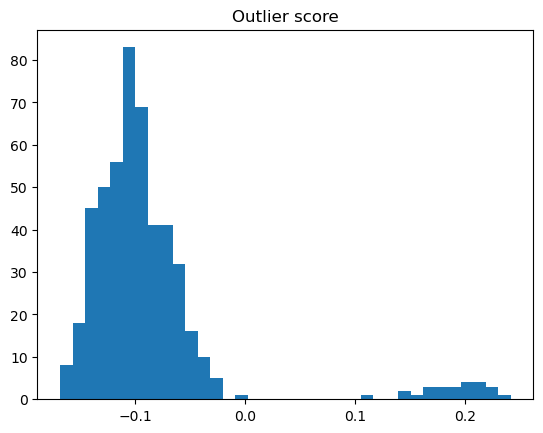

In [9]:
plt.hist(y_train_scores, bins='auto')
plt.title("Outlier score")
plt.show()

In [10]:
threshold = isft.threshold_ # Or other value from the above histogram
feature_list = ['Feature_1', 'Feature_2', 'Feature_3',
                'Feature_4', 'Feature_5', 'Feature_6']
descriptive_stat_threshold(X_train, feature_list, y_train_scores, threshold).T

,0,1
Group,Normal,Outlier
Count,475,25
Count %,95.0,5.0
Feature_1,3.0,4.55
Feature_2,2.99,5.21
Feature_3,2.99,5.47
Feature_4,3.01,5.23
Feature_5,2.99,5.03
Feature_6,3.02,5.06
Anomaly_Score,-0.1,0.19


In [11]:
descriptive_stat_threshold(X_test, feature_list, y_test_scores, threshold).T

,0,1
Group,Normal,Outlier
Count,475,25
Count %,95.0,5.0
Feature_1,2.98,5.0
Feature_2,2.99,5.54
Feature_3,2.99,5.23
Feature_4,3.01,5.05
Feature_5,2.99,5.06
Feature_6,3.0,4.88
Anomaly_Score,-0.1,0.19


In [12]:
confusion_matrix1(y_train, y_train_scores, threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [13]:
confusion_matrix1(y_test, y_test_scores, threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


# Aggregate multiple models

IForest is a proximity-based algorithm. It can be sensitive to outliers and prone to overfitting. Aggregating the predictions of the models can achieve model stability.

In [18]:
# Test a range of n_estimators
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

In [19]:
# Modeling
for i in range(n_clf):
    k = k_list[i]
    isft = IForest(contamination=0.05, n_estimators=k)
    isft.fit(X_train)

    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(X_train)
    test_scores[:, i] = isft.decision_function(X_test)

In [20]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [21]:
# Combination by average
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

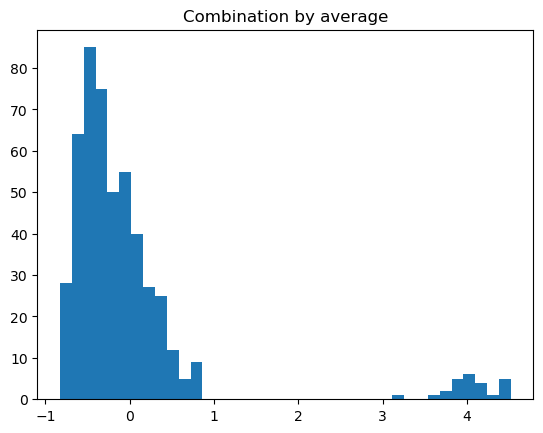

In [23]:
plt.hist(y_train_by_average, bins='auto')
plt.title("Combination by average")
plt.show()

In [25]:
descriptive_stat_threshold(X_train, feature_list, y_train_by_average, 1.5).T

,0,1
Group,Normal,Outlier
Count,475,25
Count %,95.0,5.0
Feature_1,3.0,4.55
Feature_2,2.99,5.21
Feature_3,2.99,5.47
Feature_4,3.01,5.23
Feature_5,2.99,5.03
Feature_6,3.02,5.06
Anomaly_Score,-0.21,4.06


In [26]:
descriptive_stat_threshold(X_test, feature_list, y_test_by_average, 1.5).T

,0,1
Group,Normal,Outlier
Count,475,25
Count %,95.0,5.0
Feature_1,2.98,5.0
Feature_2,2.99,5.54
Feature_3,2.99,5.23
Feature_4,3.01,5.05
Feature_5,2.99,5.06
Feature_6,3.0,4.88
Anomaly_Score,-0.19,4.13
